# Linear Regression - GMST

In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from utils import *

from eofs.xarray import Eof

In [2]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Y = create_predictdand_data(train_files) # Already changes units of precipitation
Y = xr.open_dataset('/glade/u/home/ianderson/train_test/y_train_outputs.nc')

In [3]:
Y.compute()

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, year: 423)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables:
    tas      (year, lat, lon) float32 -0.1424 -0.1424 -0.1424 ... 11.68 11.68
    pr       (year, lat, lon) float32 0.000513 0.000513 ... 0.3538 0.3538
    huss     (year, lat, lon) float32 -1.108e-06 -1.108e-06 ... 0.001122
    hurs     (year, lat, lon) float32 0.09258 0.09261 0.09261 ... -8.373 -8.373
    rlds     (year, lat, lon) float32 0.9069 0.9063 0.9063 ... 57.51 57.51 57.51
    rsds     (year, lat, lon) float32 -1.53 -1.529 -1.529 ... -27.29 -27.29
    sfcWind  (year, lat, lon) float32 -0.03228 -0.03229 -0.03229 ... 1.168 1.168
    ps       (year, lat, lon) float32 -117.7 -117.7 -117.7 ... -330.5 -330.5
    mrsos    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    evspsbl  (year, lat, lon) float32 -6.049e-10 -6.192e-10 ... 3.421e-06

In [4]:
X = xr.concat([xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_historical.nc'), xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp585.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp126.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp370.nc')], dim='time')

In [5]:
X["time"]=np.arange(1,424) 
Y["time"]=np.arange(1,424)

In [6]:
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [7]:
y_inp_tas=Y["tas"].stack(dim=["lat", "lon"])
y_inp_pr=Y["pr"].stack(dim=["lat", "lon"])
y_inp_huss=Y["huss"].stack(dim=["lat", "lon"])
y_inp_hurs=Y["hurs"].stack(dim=["lat", "lon"])
y_inp_rlds=Y["rlds"].stack(dim=["lat", "lon"])
y_inp_rsds=Y["rsds"].stack(dim=["lat", "lon"])
y_inp_sfcWind=Y["sfcWind"].stack(dim=["lat", "lon"])
y_inp_ps=Y["ps"].stack(dim=["lat", "lon"])
y_inp_mrsos=Y["mrsos"].stack(dim=["lat", "lon"])
y_inp_evspsbl=Y["evspsbl"].stack(dim=["lat", "lon"])

In [10]:
y_inp_mrsos = y_inp_mrsos.fillna(0.) # setting nan (ocean grid points) to be 0 for now

In [11]:
reg0 = LinearRegression(fit_intercept=False)
reg1 = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=False)
reg3 = LinearRegression(fit_intercept=False)
reg4 = LinearRegression(fit_intercept=False)
reg5 = LinearRegression(fit_intercept=False)
reg6 = LinearRegression(fit_intercept=False)
reg7 = LinearRegression(fit_intercept=False)
reg8 = LinearRegression(fit_intercept=False)
reg9 = LinearRegression(fit_intercept=False)

lr_tas = reg0.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_tas)
lr_pr = reg1.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_pr)
lr_huss = reg2.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_huss)
lr_hurs = reg3.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_hurs)
lr_rlds = reg4.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_rlds)
lr_rsds = reg5.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_rsds)
lr_sfcWind = reg6.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_sfcWind)
lr_ps = reg7.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_ps)
lr_mrsos = reg8.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_mrsos)
lr_evspsbl = reg9.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_evspsbl)

In [12]:
# Testing on ssp245, already imported 245 for plotting above
test_Y = xr.open_dataset('/glade/u/home/ianderson/train_test/y_test_outputs.nc').compute()
test_X = xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp245.nc').compute()

In [13]:
test_X=test_X.rename({'time':'year'})

In [14]:
test_Y

<xarray.Dataset>
Dimensions:  (year: 86, lat: 192, lon: 288)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (year, lat, lon) float32 1.339 1.339 1.339 ... 9.46 9.46 9.459
    pr       (year, lat, lon) float32 0.01312 0.01312 0.01312 ... 0.1616 0.1615
    huss     (year, lat, lon) float32 9.854e-06 9.854e-06 ... 0.0008405
    hurs     (year, lat, lon) float32 0.1634 0.1634 0.1634 ... -6.797 -6.797
    rlds     (year, lat, lon) float32 4.132 4.132 4.132 ... 43.28 43.28 43.28
    rsds     (year, lat, lon) float32 0.6355 0.6353 0.6353 ... -20.81 -20.81
    sfcWind  (year, lat, lon) float32 -0.1045 -0.1045 -0.1045 ... 0.8908 0.8907
    ps       (year, lat, lon) float32 -137.5 -137.5 -137.5 ... 15.88 15.88 15.88
    evspsbl  (year, lat, lon) float32 5.2e-10 5.217e-10 ... 1.076e-06 1.077e-06
    mrsos    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [15]:
tas_truth = test_Y["tas"]
pr_truth = test_Y["pr"]
huss_truth = test_Y["huss"]
hurs_truth = test_Y["hurs"]
rlds_truth = test_Y["rlds"]
rsds_truth = test_Y["rsds"]
sfcWind_truth = test_Y["sfcWind"]
ps_truth = test_Y["ps"]
mrsos_truth = test_Y["mrsos"]
evspsbl_truth = test_Y["evspsbl"]

In [16]:
test_inputs = test_Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()

In [17]:
test_inputs

year
2015    1.301202
2016    1.212808
2017    1.167027
2018    1.153813
2019    1.150449
          ...   
2096    3.338427
2097    3.361185
2098    3.374997
2099    3.391313
2100    3.412900
Length: 86, dtype: float64

In [18]:
m_out_t = lr_tas.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_precip = lr_pr.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_hus = lr_huss.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_hur = lr_hurs.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_rl = lr_rlds.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_rs = lr_rsds.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_sfc = lr_sfcWind.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p = lr_ps.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_mr = lr_mrsos.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_ev = lr_evspsbl.predict(test_inputs.to_numpy()[:, np.newaxis])

m_out_tas = m_out_t.reshape(86, 192, 288)
m_out_pr = m_out_precip.reshape(86, 192, 288)
m_out_huss = m_out_hus.reshape(86, 192, 288)
m_out_hurs = m_out_hur.reshape(86, 192, 288)
m_out_rlds = m_out_rl.reshape(86, 192, 288)
m_out_rsds = m_out_rs.reshape(86, 192, 288)
m_out_sfcWind = m_out_sfc.reshape(86, 192, 288)
m_out_ps = m_out_p.reshape(86, 192, 288)
m_out_mrsos = m_out_mr.reshape(86, 192, 288)
m_out_evspsbl = m_out_ev.reshape(86, 192, 288)

In [19]:
xr_output=xr.Dataset(coords={'time': test_Y.year.values, 'lat': test_Y.lat.values, 'lon': test_Y.lon.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["huss"]=(['time', 'lat', 'lon'],  m_out_huss)
xr_output["hurs"]=(['time', 'lat', 'lon'],  m_out_hurs)
xr_output["rlds"]=(['time', 'lat', 'lon'],  m_out_rlds)
xr_output["rsds"]=(['time', 'lat', 'lon'],  m_out_rsds)
xr_output["sfcWind"]=(['time', 'lat', 'lon'],  m_out_sfcWind)
xr_output["ps"]=(['time', 'lat', 'lon'],  m_out_ps)
xr_output["mrsos"]=(['time', 'lat', 'lon'],  m_out_mrsos)
xr_output["evspsbl"]=(['time', 'lat', 'lon'],  m_out_evspsbl)

In [58]:
print('tas: Near Surface Air Temperature')
print(f"RMSE 2080-2100: {get_rmse(tas_truth[65:], m_out_tas[65:])}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], m_out_tas[35:])}")
print("\n")

print('pr: Precipitation')
print(f"RMSE 2080-2100: {get_rmse(pr_truth[65:], m_out_pr[65:])}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], m_out_pr[35:])}")
print("\n")

tas: Near Surface Air Temperature
RMSE 2080-2100: 0.44220015197107687
RMSE 2050-2100: 0.4288755035585485


pr: Precipitation
RMSE 2080-2100: 0.5682447481901001
RMSE 2050-2100: 0.5679448107748227




In [59]:
print('huss: Near Surface Specific Humidity')
print(f"RMSE 2080-2100: {get_rmse(huss_truth[65:], m_out_huss[65:])}")
print(f"RMSE 2050-2100: {get_rmse(huss_truth[35:], m_out_huss[35:])}")
print("\n")

print('hurs: Near Surface Relative Humidity')
print(f"RMSE 2080-2100: {get_rmse(hurs_truth[65:], m_out_hurs[65:])}")
print(f"RMSE 2050-2100: {get_rmse(hurs_truth[35:], m_out_hurs[35:])}")
print("\n")

huss: Near Surface Specific Humidity
RMSE 2080-2100: 0.0002918302799473505
RMSE 2050-2100: 0.00027962707604664696


hurs: Near Surface Relative Humidity
RMSE 2080-2100: 0.9755387233511973
RMSE 2050-2100: 0.973969060154418




In [60]:
print('rlds: Surface Downwelling Longwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rlds_truth[65:], m_out_rlds[65:])}")
print(f"RMSE 2050-2100: {get_rmse(rlds_truth[35:], m_out_rlds[35:])}")
print("\n")

print('rsds: Surface Downwelling Shortwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rsds_truth[65:], m_out_rsds[65:])}")
print(f"RMSE 2500-2100: {get_rmse(rsds_truth[35:], m_out_rsds[35:])}")
print("\n")

rlds: Surface Downwelling Longwave Radiation
RMSE 2080-2100: 2.7357655996600987
RMSE 2050-2100: 2.6842921671650184


rsds: Surface Downwelling Shortwave Radiation
RMSE 2080-2100: 4.845428770250838
RMSE 2500-2100: 4.625581292892572




In [61]:
print('sfcWind: Near-Surface wind speed')
print(f"RMSE 2080-2100: {get_rmse(sfcWind_truth[65:], m_out_sfcWind[65:])}")
print(f"RMSE 2050-2100: {get_rmse(sfcWind_truth[35:], m_out_sfcWind[35:])}")
print("\n")

print('ps: surface air pressure')
print(f"RMSE 2080-2100: {get_rmse(ps_truth[65:], m_out_ps[65:])}")
print(f"RMSE 2050-2100: {get_rmse(ps_truth[35:], m_out_ps[35:])}")
print("\n")

sfcWind: Near-Surface wind speed
RMSE 2080-2100: 0.20397864016510342
RMSE 2050-2100: 0.2057353551802699


ps: surface air pressure
RMSE 2080-2100: 78.34655201594694
RMSE 2050-2100: 77.15593724436677




In [62]:
print('mrsos:land-surface moistrure')
# print(f"RMSE at 2050: {get_rmse(mrsos_truth[35], m_out_mrsos[35])}")
# print(f"RMSE at 2100: {get_rmse(mrsos_truth[85], m_out_mrsos[85])}")
# print(f"RMSE 2045-2055: {get_rmse(mrsos_truth[30:41], m_out_mrsos[30:41]).mean()}")
print(f"RMSE 2080-2100: {get_rmse(mrsos_truth[65:], m_out_mrsos[65:])}")
# print(f"RMSE 2090-2100: {get_rmse(mrsos_truth[75:], m_out_mrsos[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(mrsos_truth[35:], m_out_mrsos[35:]).mean()}")
print("\n")

print('evspsbl: surface evaporation')
# print(f"RMSE at 2050: {get_rmse(evspsbl_truth[35], m_out_evspsbl[35])}")
# print(f"RMSE at 2100: {get_rmse(evspsbl_truth[85], m_out_evspsbl[85])}")
# print(f"RMSE 2045-2055: {get_rmse(evspsbl_truth[30:41], m_out_evspsbl[30:41]).mean()}")
print(f"RMSE 2080-2100: {get_rmse(evspsbl_truth[65:], m_out_evspsbl[65:])}")
# print(f"RMSE 2090-2100: {get_rmse(evspsbl_truth[75:], m_out_evspsbl[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(evspsbl_truth[35:], m_out_evspsbl[35:]).mean()}")

mrsos:land-surface moistrure
RMSE 2080-2100: 1.9706331072559646
RMSE 2050-2100: 1.9534437842330352


evspsbl: surface evaporation
RMSE 2080-2100: 1.7909393483707178e-06
RMSE 2050-2100: 1.7042568877309682e-06


### Plotting scenarios and predicted

In [26]:
tas_out = xr.DataArray(m_out_tas, dims=('year', 'lat', 'lon'))
x = range(2015,2101)

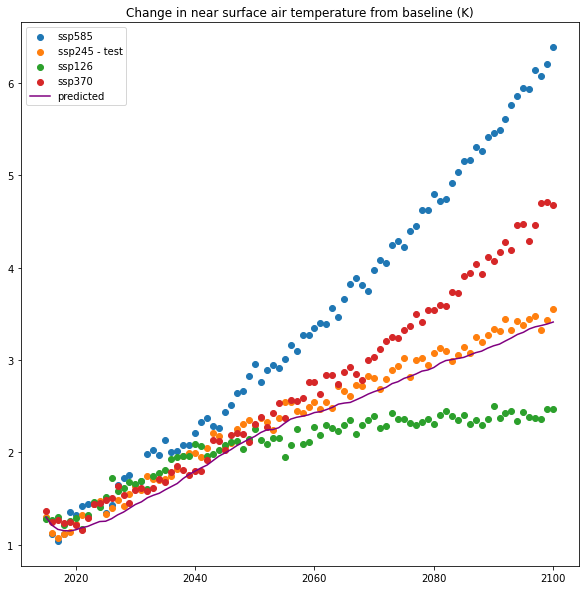

In [35]:
plt.figure(figsize=(10, 10))
plt.scatter(x, Y['tas'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['tas'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['tas'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['tas'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, tas_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in near surface air temperature from baseline (K)")
plt.legend()

In [36]:
print(f"RMSE: {get_rmse(tas_truth[65:], m_out_tas[65:])}")
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:])}")

RMSE: 0.44220015197107687
RMSE: 0.4288755035585485


### `pr`

In [37]:
pr_out = xr.DataArray(m_out_pr, dims=('year', 'lat', 'lon'))

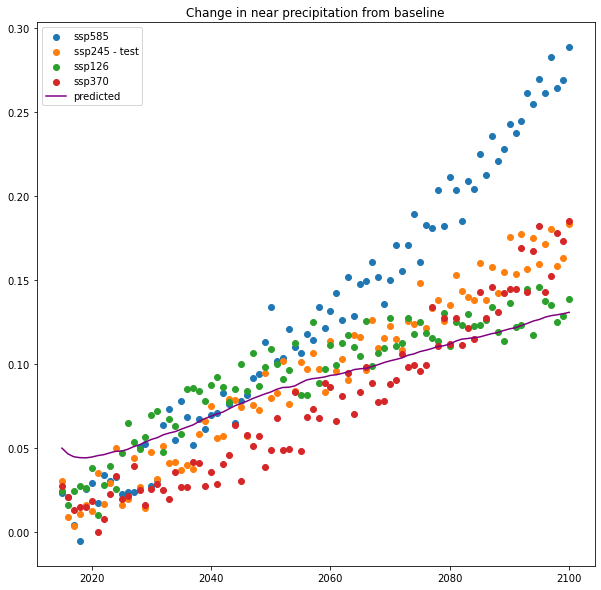

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(x, Y['pr'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['pr'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['pr'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['pr'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, pr_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in near precipitation from baseline")
plt.legend()

In [41]:
print(f"RMSE: {get_rmse(pr_truth[65:], m_out_pr[65:])}")
print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:])}")

RMSE: 0.5682447481901001
RMSE: 0.5679448107748227


### `huss`

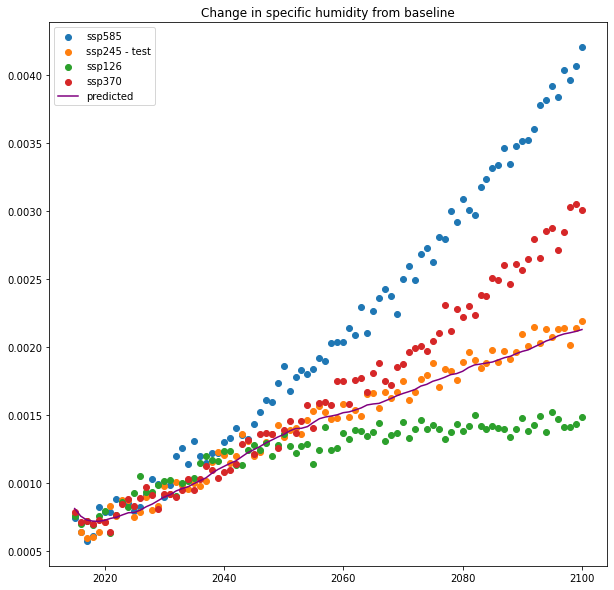

In [39]:
huss_out = xr.DataArray(m_out_huss, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['huss'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['huss'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['huss'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['huss'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, huss_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in specific humidity from baseline")
plt.legend()

In [40]:
print(f"RMSE: {get_rmse(huss_truth[65:], m_out_huss[65:])}")
print(f"RMSE: {get_rmse(huss_truth[35:], m_out_huss[35:])}")

RMSE: 0.0002918302799473505
RMSE: 0.00027962707604664696


### `hurs`

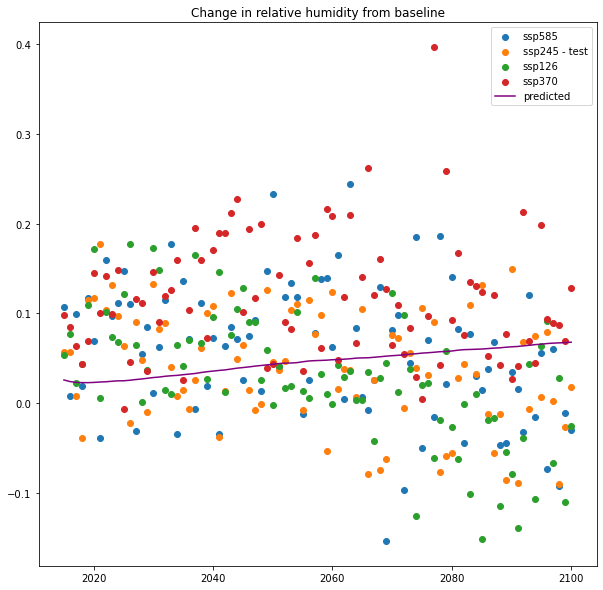

In [43]:
hurs_out = xr.DataArray(m_out_hurs, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['hurs'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['hurs'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['hurs'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['hurs'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, hurs_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in relative humidity from baseline")
plt.legend()

In [44]:
print(f"RMSE: {get_rmse(hurs_truth[65:], m_out_hurs[65:])}")
print(f"RMSE: {get_rmse(hurs_truth[35:], m_out_hurs[35:])}")

RMSE: 0.9755387233511973
RMSE: 0.973969060154418


### `rlds`

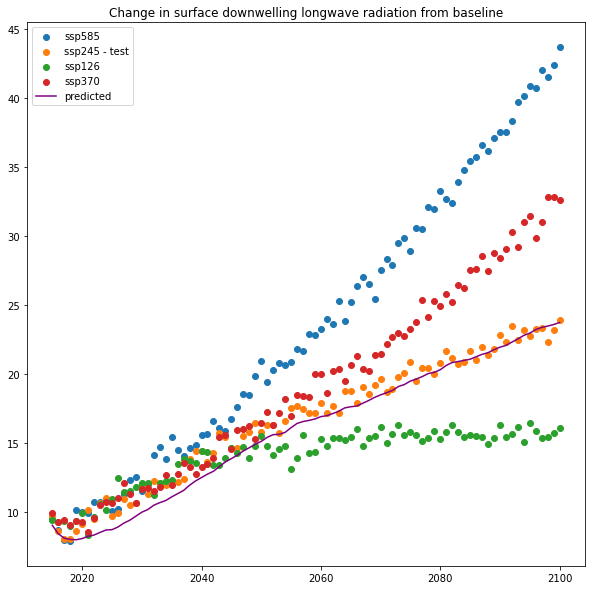

In [45]:
rlds_out = xr.DataArray(m_out_rlds, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['rlds'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['rlds'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['rlds'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['rlds'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, rlds_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface downwelling longwave radiation from baseline")
plt.legend()

In [46]:
print(f"RMSE: {get_rmse(rlds_truth[65:], m_out_rlds[65:])}")
print(f"RMSE: {get_rmse(rlds_truth[35:], m_out_rlds[35:])}")

RMSE: 2.7357655996600987
RMSE: 2.6842921671650184


### `rsds`

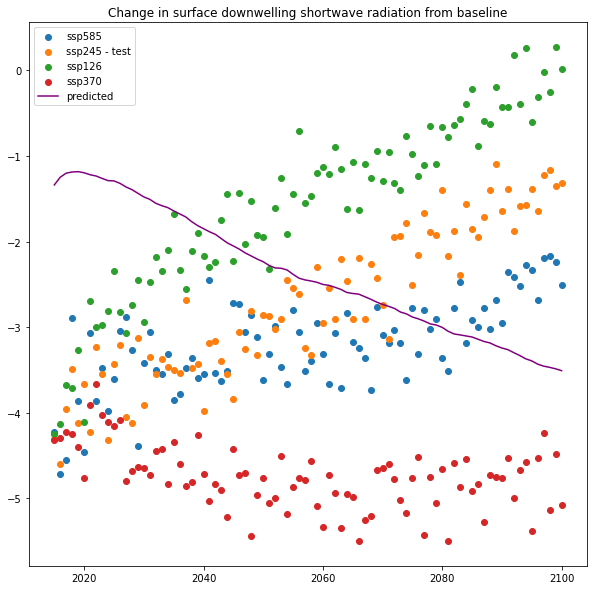

In [47]:
rsds_out = xr.DataArray(m_out_rsds, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['rsds'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['rsds'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['rsds'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['rsds'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, rsds_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface downwelling shortwave radiation from baseline")
plt.legend()

In [48]:
print(f"RMSE: {get_rmse(rsds_truth[65:], m_out_rsds[65:])}")
print(f"RMSE: {get_rmse(rsds_truth[35:], m_out_rsds[35:])}")

RMSE: 4.845428770250838
RMSE: 4.625581292892572


### `sfcWind`

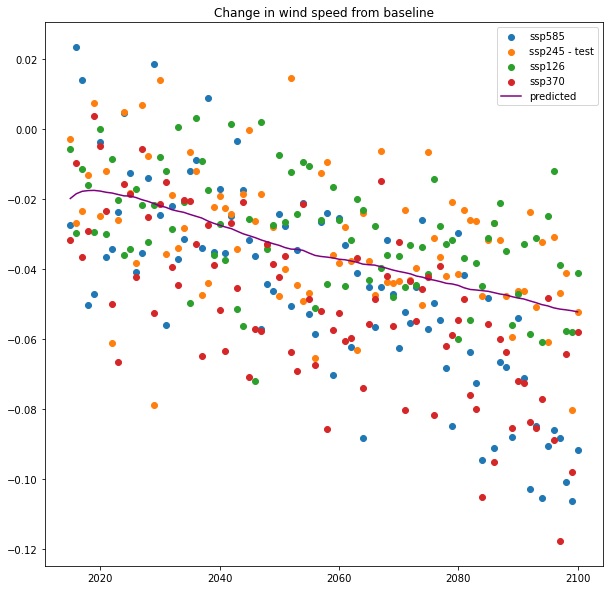

In [51]:
wind_out = xr.DataArray(m_out_sfcWind, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['sfcWind'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['sfcWind'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['sfcWind'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['sfcWind'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, wind_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in wind speed from baseline")
plt.legend()

In [49]:
print(f"RMSE: {get_rmse(sfcWind_truth[65:], m_out_sfcWind[65:])}")
print(f"RMSE: {get_rmse(sfcWind_truth[35:], m_out_sfcWind[35:])}")

RMSE: 0.20397864016510342
RMSE: 0.2057353551802699


### `ps`

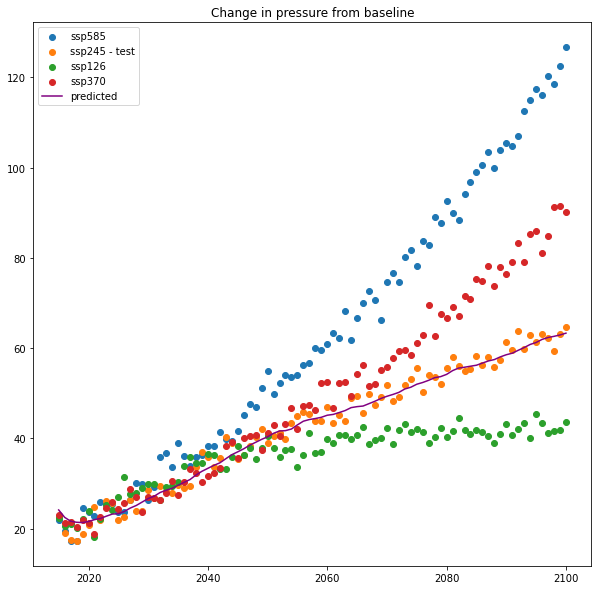

In [52]:
ps_out = xr.DataArray(m_out_ps, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['ps'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['ps'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['ps'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['ps'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, ps_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in pressure from baseline")
plt.legend()

In [53]:
print(f"RMSE: {get_rmse(ps_truth[65:], m_out_ps[65:])}")
print(f"RMSE: {get_rmse(ps_truth[35:], m_out_ps[35:])}")

RMSE: 78.34655201594694
RMSE: 77.15593724436677


### `mrsos`

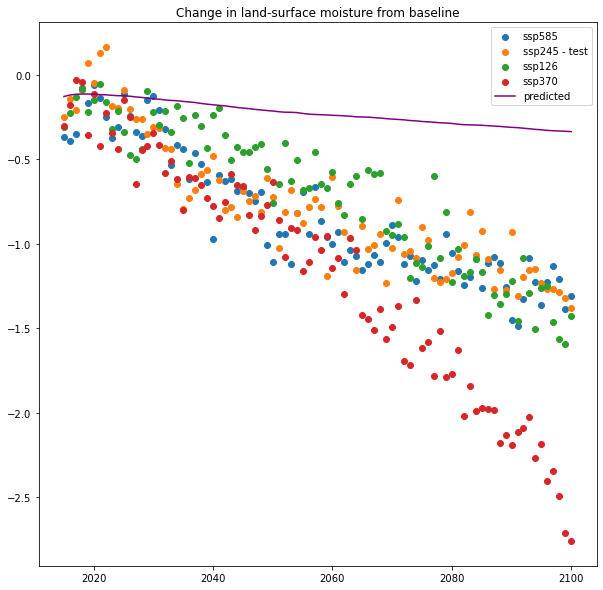

In [54]:
mrsos_out = xr.DataArray(m_out_mrsos, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['mrsos'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['mrsos'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['mrsos'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['mrsos'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, mrsos_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in land-surface moisture from baseline")
plt.legend()

In [55]:
print(f"RMSE: {get_rmse(mrsos_truth[65:], m_out_mrsos[65:])}")
print(f"RMSE: {get_rmse(mrsos_truth[35:], m_out_mrsos[35:])}")

RMSE: 1.9706331072559646
RMSE: 1.9534437842330352


### `evspsbl`

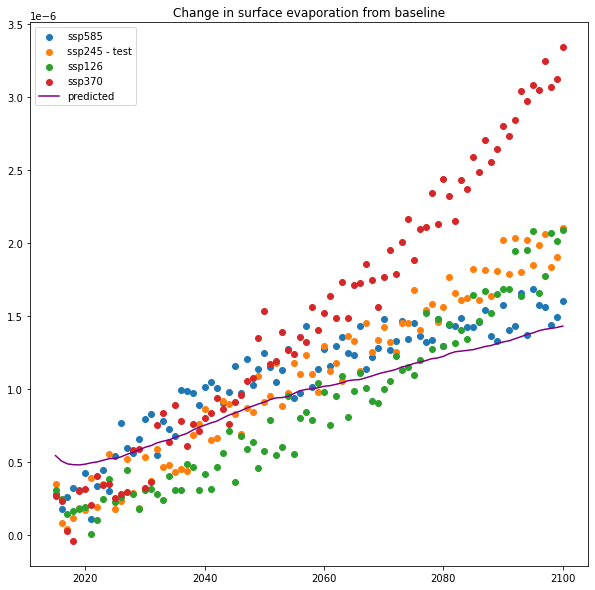

In [56]:
evspsbl_out = xr.DataArray(m_out_evspsbl, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(10, 10))
plt.scatter(x, Y['evspsbl'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.scatter(x, test_Y['evspsbl'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, Y['evspsbl'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, Y['evspsbl'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.plot(x, evspsbl_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface evaporation from baseline")
plt.legend()

In [57]:
print(f"RMSE: {get_rmse(evspsbl_truth[65:], m_out_evspsbl[65:])}")
print(f"RMSE: {get_rmse(evspsbl_truth[35:], m_out_evspsbl[35:])}")

RMSE: 1.7909393483707178e-06
RMSE: 1.7042568877309682e-06
